<a href="https://colab.research.google.com/github/PIRomanCod/DataSciense_HW/blob/main/HW_7_recomendation_systems_surprise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Імпорти

In [3]:
!pip install scikit-surprise
!pip install scikit-optimize
!pip install pandas-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3097768 sha256=1c09b5e7c4a8f2504c3804d2dd29ec094971360e5d42eeae6cc61146c80b0886
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
from surprise import SVD, SVDpp, NMF
from surprise import Dataset
from surprise.model_selection import cross_validate
from scipy.io import loadmat
from scipy.optimize import minimize
import pandas as pd
from IPython.display import display_html


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

def display_side_by_side(*args):
  html_str = ""
  for df in args:
    html_str += df.to_html()
  display_html(html_str.replace("table", "table style=display:inline"), raw=True)



# Перша частина

Пропонуємо вам познайомитись з бібліотекою surprise, котра якраз є по суті додатком до знайомої нам бібліотеки scikit-learn для тренування моделей рекомендаційних систем.

Візьміть датасет movielens і побудуйте модель матричної факторизації. У даній бібліотеці він має назву SVD. Підберіть найкращі параметри за допомогою крос-валідації, також поекспериментуйте з іншими алгоритмами розрахунків (SVD++, NMF) і оберіть той, який буде оптимальним

## Завантаження датасету MovieLens

In [9]:
data = Dataset.load_builtin('ml-100k')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


## EDA by hand

Загальна інформація про дані:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    100000 non-null  object 
 1   item_id    100000 non-null  object 
 2   rating     100000 non-null  float64
 3   timestamp  100000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.1+ MB
None 

Розподіл оцінок:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64 

Кількість оцінок, зроблених кожним користувачем (топ-10 користувачів):
405    737
655    685
13     636
450    540
276    518
416    493
537    490
303    484
234    480
393    448
Name: user_id, dtype: int64 

Кількість оцінок для кожного фільму (топ-10 фільмів):
50     583
258    509
100    508
181    507
294    485
286 

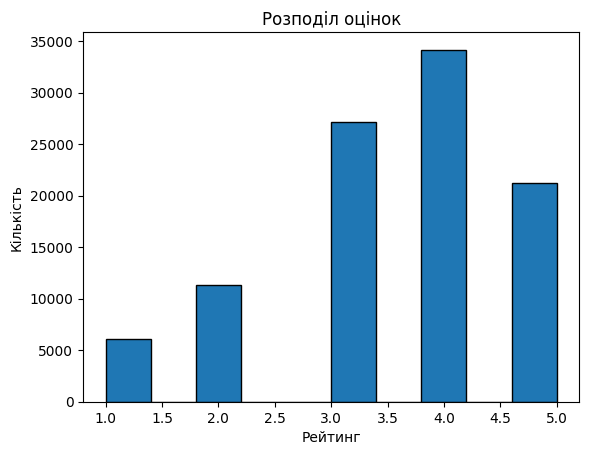

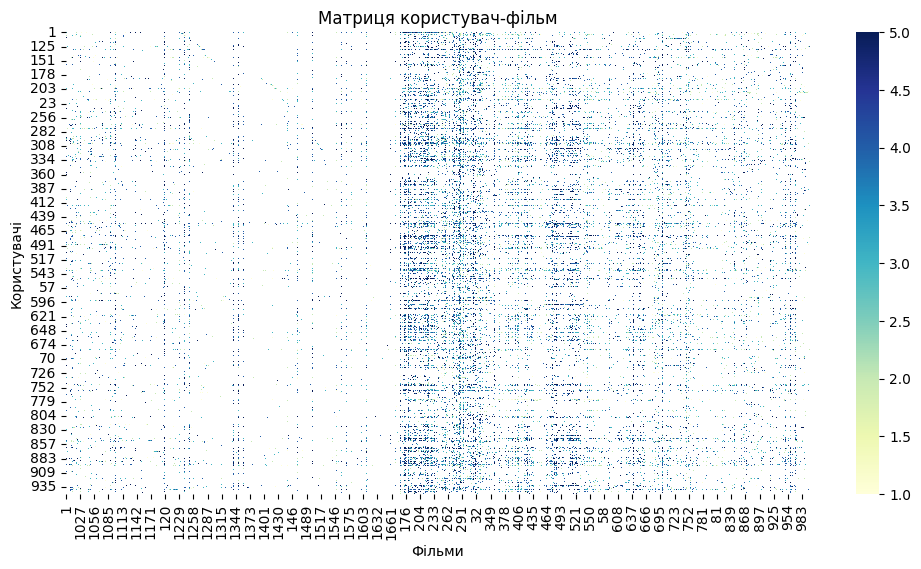

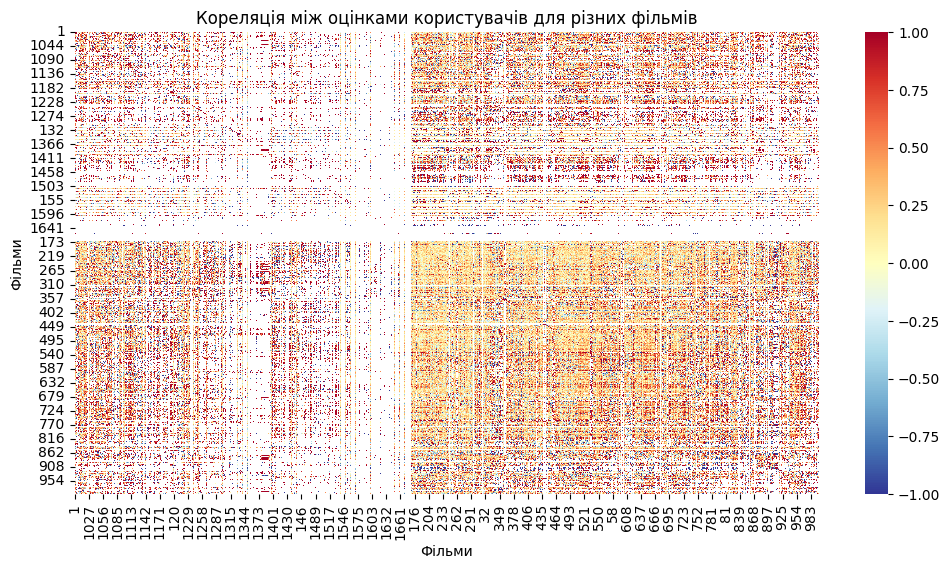

In [10]:
df = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])

# Дослідження загальної структури даних
print("Загальна інформація про дані:")
print(df.info(), "\n")

# Розподіл оцінок
print("Розподіл оцінок:")
print(df['rating'].describe(), "\n")

# Дослідження користувачів та фільмів
user_counts = df['user_id'].value_counts()
movie_counts = df['item_id'].value_counts()

print("Кількість оцінок, зроблених кожним користувачем (топ-10 користувачів):")
print(user_counts.head(10), "\n")

print("Кількість оцінок для кожного фільму (топ-10 фільмів):")
print(movie_counts.head(10), "\n")

# Візуалізація розподілу оцінок
plt.hist(df['rating'], bins=10, edgecolor='black')
plt.xlabel('Рейтинг')
plt.ylabel('Кількість')
plt.title('Розподіл оцінок')
plt.show()

ratings_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating')

# Візуалізація матриці користувач-фільм
plt.figure(figsize=(12, 6))
sns.heatmap(ratings_matrix, cmap='YlGnBu')
plt.title('Матриця користувач-фільм')
plt.xlabel('Фільми')
plt.ylabel('Користувачі')
plt.show()

# Кореляція між оцінками користувачів для різних фільмів
correlation_matrix = ratings_matrix.corr()

# Візуалізація матриці кореляції
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, cmap='RdYlBu_r', center=0)
plt.title('Кореляція між оцінками користувачів для різних фільмів')
plt.xlabel('Фільми')
plt.ylabel('Фільми')
plt.show()

## EDA with pandas_profiling

!!! Запускати при наявністі вільного ОЗУ !!!

In [ ]:
df = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])

# Створення звіту EDA за допомогою pandas_profiling
profile = pandas_profiling.ProfileReport(df)
profile.to_file("data_eda_report.html")  # Збереження звіту в HTML


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
profile

NameError: ignored

## Крос-валідація для оцінки точності моделей

Формуємо список алгоритмів - аlgorithms

In [12]:
algo_1 = SVD()
algo_2 = SVDpp()
algo_3 = NMF()
algorithms = [algo_1, algo_2, algo_3]

Оцінюємо у циклі усі алгоритми та записуємо результати

In [13]:
results = []
for algorithm in algorithms:
  result = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
  results.append((algorithm, result))

  #print(result)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9336  0.9407  0.9337  0.9390  0.9372  0.9368  0.0028  
MAE (testset)     0.7356  0.7428  0.7353  0.7392  0.7389  0.7384  0.0028  
Fit time          3.26    4.87    1.83    1.53    1.44    2.59    1.32    
Test time         0.97    0.32    0.15    0.14    0.15    0.35    0.32    
Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9155  0.9139  0.9204  0.9188  0.9238  0.9185  0.0035  
MAE (testset)     0.7192  0.7164  0.7230  0.7214  0.7240  0.7208  0.0027  
Fit time          29.01   34.65   34.54   30.64   27.30   31.23   2.95    
Test time         5.79    4.26    7.37    4.45    6.34    5.64    1.17    
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (tests

Вибираємо найкращій з алгоритмів, надаючи перевагу точності над часом (ваги легко переналаштовуються та аналогічно додаються до вагів ще 2 показника за потреби)

In [17]:
best_weighted_error = float('inf')
best_algorithm = None
best_test_time = None

rmse_weight = 0.6  # Вага для RMSE
test_time_weight = 0.4  # Вага для test_time

for algorithm, result in results:
    rmse = np.mean(result['test_rmse'])
    test_time = np.mean(result['test_time'])

    weighted_error = rmse_weight * rmse + test_time_weight * test_time

    if weighted_error < best_weighted_error:
        best_weighted_error = weighted_error
        best_algorithm = algorithm
        best_test_time = test_time

print(f"Найкраща збалансована модель: {best_algorithm}")
print(f"Сумарна зважена похибка: {best_weighted_error:.4f}")
print(f"Зважений час виконання: {best_test_time:.4f} сек")

Найкраща збалансована модель: <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7c07d5734850>
Сумарна зважена похибка: 0.6773
Зважений час виконання: 0.2460 сек


# Друга частина

## Рекомендаційні системи. Теорія та підсказки


In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings ([MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/) from GroupLens Research). This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies.

In the next parts of this exercise, you will implement the function `cofiCostFunc` that computes the collaborative filtering objective function and gradient. After implementing the cost function and gradient, you will use `scipy.optimize.minimize` to learn the parameters for collaborative filtering.

### 2.1 Movie ratings dataset

The next cell will load the dataset `movies.mat`, providing the variables `Y` and `R`.
The matrix `Y` (a `num_movies` $\times$ `num_users` matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix `R` is an binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

To help you understand the matrix `Y`, the following cell will compute the average movie rating for the first movie (Toy Story) and print its average rating.

Throughout this part of the exercise, you will also be working with the matrices, `X` and `W`:

$$ \text{X} =
\begin{bmatrix}
- \left(x^{(1)}\right)^T - \\
- \left(x^{(2)}\right)^T - \\
\vdots \\
- \left(x^{(n_m)}\right)^T - \\
\end{bmatrix}, \quad
\text{W} =
\begin{bmatrix}
- \left(w^{(1)}\right)^T - \\
- \left(w^{(2)}\right)^T - \\
\vdots \\
- \left(w^{(n_u)}\right)^T - \\
\end{bmatrix}.
$$

The $i^{th}$ row of `X` corresponds to the feature vector $x^{(i)}$ for the $i^{th}$ movie, and the $j^{th}$ row of `W` corresponds to one parameter vector $w^{(j)}$, for the $j^{th}$ user. Both $x^{(i)}$ and $w^{(j)}$ are n-dimensional vectors. For the purposes of this exercise, you will use $n = 100$, and therefore, $x^{(i)} \in \mathbb{R}^{100}$ and $w^{(j)} \in \mathbb{R}^{100}$. Correspondingly, `X` is a $n_m \times 100$ matrix and `W` is a $n_u \times 100$ matrix.

<a id="section3"></a>
### 2.2 Collaborative filtering learning algorithm

Now, you will start implementing the collaborative filtering learning algorithm. You will start by implementing the cost function (without regularization).

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)}, \dots, x^{(n_m)}$ and $w^{(1)} , \dots, w^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = \left( w^{(j)} \right)^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, \dots, x^{(n_m)}, w^{(1)}, \dots, w^{(n_u)}$ that produce the best fit (minimizes the squared error).

You will complete the code in `cofiCostFunc` to compute the cost function and gradient for collaborative filtering. Note that the parameters to the function (i.e., the values that you are trying to learn) are `X` and `W`. In order to use an off-the-shelf minimizer such as `scipy`'s `minimize` function, the cost function has been set up to unroll the parameters into a single vector called `params`. You had previously used the same vector unrolling method in the neural networks programming exercise.

#### 2.2.1 Collaborative filtering cost function

The collaborative filtering cost function (without regularization) is given by

$$
J(x^{(1)}, \dots, x^{(n_m)}, w^{(1)}, \dots, w^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(w^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2
$$

You should now modify the function `cofiCostFunc` to return this cost in the variable `J`. Note that you should be accumulating the cost for user $j$ and movie $i$ only if `R[i,j] = 1`.

<div class="alert alert-block alert-warning">
**Implementation Note**: We strongly encourage you to use a vectorized implementation to compute $J$, since it will later by called many times by `scipy`'s optimization package. As usual, it might be easiest to first write a non-vectorized implementation (to make sure you have the right answer), and the modify it to become a vectorized implementation (checking that the vectorization steps do not change your algorithm’s output). To come up with a vectorized implementation, the following tip might be helpful: You can use the $R$ matrix to set selected entries to 0. For example, `R * M` will do an element-wise multiplication between `M`
and `R`; since `R` only has elements with values either 0 or 1, this has the effect of setting the elements of M to 0 only when the corresponding value in R is 0. Hence, `np.sum( R * M)` is the sum of all the elements of `M` for which the corresponding element in `R` equals 1.
</div>

<a id="cofiCostFunc"></a>

<a id="section4"></a>
#### 2.2.2 Collaborative filtering gradient

Now you should implement the gradient (without regularization). Specifically, you should complete the code in `cofiCostFunc` to return the variables `X_grad` and `W_grad`. Note that `X_grad` should be a matrix of the same size as `X` and similarly, `W_grad` is a matrix of the same size as
`W`. The gradients of the cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(w^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) w_k^{(j)} $$

$$ \frac{\partial J}{\partial w_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(w^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} $$

Note that the function returns the gradient for both sets of variables by unrolling them into a single vector. After you have completed the code to compute the gradients, the next cell run a gradient check
(available in `utils.checkCostFunction`) to numerically check the implementation of your gradients (this is similar to the numerical check that you used in the neural networks exercise. If your implementation is correct, you should find that the analytical and numerical gradients match up closely.

<div class="alert alert-block alert-warning">
**Implementation Note:** You can get full credit for this assignment without using a vectorized implementation, but your code will run much more slowly (a small number of hours), and so we recommend that you try to vectorize your implementation. To get started, you can implement the gradient with a for-loop over movies
(for computing $\frac{\partial J}{\partial x^{(i)}_k}$) and a for-loop over users (for computing $\frac{\partial J}{w_k^{(j)}}$). When you first implement the gradient, you might start with an unvectorized version, by implementing another inner for-loop that computes each element in the summation. After you have completed the gradient computation this way, you should try to vectorize your implementation (vectorize the inner for-loops), so that you are left with only two for-loops (one for looping over movies to compute $\frac{\partial J}{\partial x_k^{(i)}}$ for each movie, and one for looping over users to compute $\frac{\partial J}{\partial w_k^{(j)}}$ for each user).
</div>

<div class="alert alert-block alert-warning">
**Implementation Tip:** To perform the vectorization, you might find this helpful: You should come up with a way to compute all the derivatives associated with $x_1^{(i)} , x_2^{(i)}, \dots , x_n^{(i)}$ (i.e., the derivative terms associated with the feature vector $x^{(i)}$) at the same time. Let us define the derivatives for the feature vector of the $i^{th}$ movie as:

$$ \left(X_{\text{grad}} \left(i, :\right)\right)^T =
\begin{bmatrix}
\frac{\partial J}{\partial x_1^{(i)}} \\
\frac{\partial J}{\partial x_2^{(i)}} \\
\vdots \\
\frac{\partial J}{\partial x_n^{(i)}}
\end{bmatrix} = \quad
\sum_{j:r(i,j)=1} \left( \left( w^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right) w^{(j)}
$$

To vectorize the above expression, you can start by indexing into `W` and `Y` to select only the elements of interests (that is, those with `r[i, j] = 1`). Intuitively, when you consider the features for the $i^{th}$ movie, you only need to be concerned about the users who had given ratings to the movie, and this allows you to remove all the other users from `W` and `Y`. <br/><br/>


Concretely, you can set `idx = np.where(R[i, :] == 1)[0]` to be a list of all the users that have rated movie $i$. This will allow you to create the temporary matrices `W_temp = W[idx, :]` and `Y_temp = Y[i, idx]` that index into `W` and `Y` to give you only the set of users which have rated the $i^{th}$ movie. This will allow you to write the derivatives as: <br>

`X_grad[i, :] = np.dot(np.dot(X[i, :], W_temp.T) - Y_temp, W_temp)`

<br><br>
Note that the vectorized computation above returns a row-vector instead. After you have vectorized the computations of the derivatives with respect to $x^{(i)}$, you should use a similar method to vectorize the derivatives with respect to $w^{(j)}$ as well.
</div>

<a id="section5"></a>
#### 2.2.3 Regularized cost function

The cost function for collaborative filtering with regularization is given by

$$ J(x^{(1)}, \dots, x^{(n_m)}, w^{(1)}, \dots, w^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( w^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( w_k^{(j)} \right)^2  \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$

You should now add regularization to your original computations of the cost function, $J$. After you are done, the next cell will run your regularized cost function, and you should expect to see a cost of about 31.34.

<a id="section6"></a>
#### 2.2.4 Regularized gradient

Now that you have implemented the regularized cost function, you should proceed to implement regularization for the gradient. You should add to your implementation in `cofiCostFunc` to return the regularized gradient
by adding the contributions from the regularization terms. Note that the gradients for the regularized cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(w^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) w_k^{(j)} + \lambda x_k^{(i)} $$

$$ \frac{\partial J}{\partial w_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(w^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} + \lambda w_k^{(j)} $$

This means that you just need to add $\lambda x^{(i)}$ to the `X_grad[i,:]` variable described earlier, and add $\lambda w^{(j)}$ to the `W_grad[j, :]` variable described earlier.

### 2.3 Learning movie recommendations

After you have finished implementing the collaborative filtering cost function and gradient, you can now start training your algorithm to make movie recommendations for yourself. In the next cell, you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations! We have filled out some values according to our own preferences, but you should change this according to your own tastes. The list of all movies and their number in the dataset can be found listed in the file `Data/movie_idx.txt`.

#### 2.3.1 Recommendations

After the additional ratings have been added to the dataset, the script
will proceed to train the collaborative filtering model. This will learn the
parameters `X` and `W`. To predict the rating of movie $i$ for user $j$, you need to compute $(w^{(j)})^T x^{(i)}$ . The next part of the script computes the ratings for
all the movies and users and displays the movies that it recommends (Figure
4), according to ratings that were entered earlier in the script. Note that
you might obtain a different set of the predictions due to different random
initializations.

## Завантаження даних

Завантажимо список фільмів

In [128]:
def loadMovieList(file_path):
    """
    Reads the fixed movie list in movie_ids.txt and returns a list of movie names.
    Returns
    -------
    movieNames : list
        A list of strings, representing all movie names.
    """
    with open(file_path, encoding='ISO-8859-1') as fid:
        movies = fid.readlines()

    movieNames = []
    for movie in movies:
        parts = movie.split()
        movieNames.append(' '.join(parts[1:]).strip())
    return movieNames

# Отримання списку назв фільмів
file_path = '/content/drive/MyDrive/Colab_Notebooks/dataHW7/movie_ids.txt'
movie_names = loadMovieList(file_path)

Завантажимо матрицю оцінок movies.mat

In [129]:
data = loadmat('/content/drive/MyDrive/Colab_Notebooks/dataHW7/movies.mat')
Y, R = data['Y'], data['R']

# Y is a 1682x943 matrix, containing ratings (1-5) of
# 1682 movies on 943 users

# R is a 1682x943 matrix, where R(i,j) = 1
# if and only if user j gave a rating to movie i

## Виведення деякої статистики з дата сету

З матриці ми можемо обчислити статистику, наприклад середній рейтинг

In [145]:
movie_index = 1
average_rating = np.mean(Y[movie_index - 1, R[movie_index - 1, :]])

print('Середній рейтинг для фільму №', movie_index, '(', movie_names[movie_index - 1], '): %.2f / 5' % average_rating)

Середній рейтинг для фільму № 1 ( Toy Story (1995) ): 4.52 / 5


Ми можемо "візуалізувати" матрицю рейтингів, побудувавши її графік за допомогою imshow

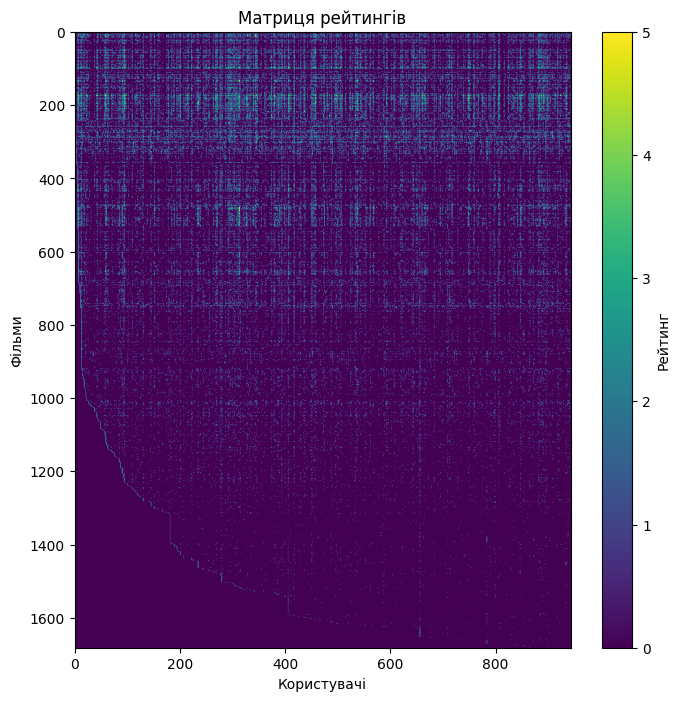

In [131]:
plt.figure(figsize=(8, 8))
plt.imshow(Y, aspect='auto', cmap='viridis')
plt.ylabel('Фільми')
plt.xlabel('Користувачі')
plt.title('Матриця рейтингів')
plt.colorbar(label='Рейтинг')
plt.grid(False)
plt.show()

Ми можемо "візуалізувати" розподіл рейтингів для фільму відповідно до movie_index.

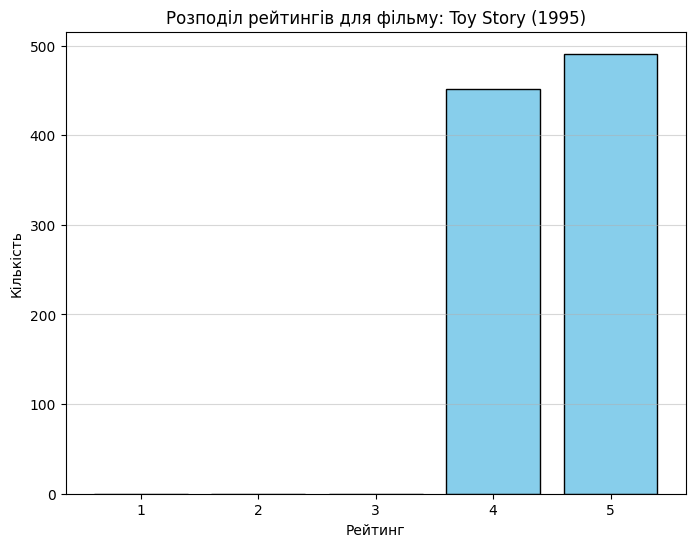

In [132]:
movie_ratings = Y[movie_index - 1, R[movie_index - 1, :]]
plt.figure(figsize=(8, 6))
plt.hist(movie_ratings, bins=np.arange(1, 7) - 0.5, rwidth=0.8, align='mid', edgecolor='black', color='skyblue')
plt.xticks(np.arange(1, 6))
plt.xlabel('Рейтинг')
plt.ylabel('Кількість')
plt.title('Розподіл рейтингів для фільму: ' + movie_names[movie_index - 1])
plt.grid(axis='y', alpha=0.5)
plt.show()

Надрукуємо 20 найкращих фільмів

In [133]:
# Обчислюємо середні рейтинги для кожного фільму
average_ratings = np.sum(Y, axis=1) / np.sum(R, axis=1)

# Створюємо список кортежів, що містить (movie_name, average_rating)
movies_with_ratings = list(zip(movie_names, average_ratings))

# Відсортуємо фільми за середніми оцінками в порядку спадання
movies_with_ratings.sort(key=lambda x: x[1], reverse=True)

print("Топ 20 фільмів:")
for i, (movie, rating) in enumerate(movies_with_ratings[:20], 1):
    print(f"{i}. {movie}: {rating:.2f} / 5")

Топ 20 фільмів:
1. Great Day in Harlem, A (1994): 5.00 / 5
2. They Made Me a Criminal (1939): 5.00 / 5
3. Prefontaine (1997): 5.00 / 5
4. Marlene Dietrich: Shadow and Light (1996): 5.00 / 5
5. Star Kid (1997): 5.00 / 5
6. Saint of Fort Washington, The (1993): 5.00 / 5
7. Santa with Muscles (1996): 5.00 / 5
8. Aiqing wansui (1994): 5.00 / 5
9. Someone Else's America (1995): 5.00 / 5
10. Entertaining Angels: The Dorothy Day Story (1996): 5.00 / 5
11. Pather Panchali (1955): 4.62 / 5
12. Maya Lin: A Strong Clear Vision (1994): 4.50 / 5
13. Anna (1996): 4.50 / 5
14. Everest (1998): 4.50 / 5
15. Some Mother's Son (1996): 4.50 / 5
16. Close Shave, A (1995): 4.49 / 5
17. Schindler's List (1993): 4.47 / 5
18. Wrong Trousers, The (1993): 4.47 / 5
19. Casablanca (1942): 4.46 / 5
20. Wallace & Gromit: The Best of Aardman Animation (1996): 4.45 / 5


## Побудова системи колобораційної фільтрації


Функція втрат

In [134]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lam=0.0):

    """
Обчислює вартість і градієнт спільної фільтрації
     функція витрат.

     Параметри
     ----------
     параметри: масив
         Параметри моделі.
     Y : масив
         Матриця рейтингів.
     R : масив
         Матриця індикаторних змінних.
     num_users : int
         Кількість користувачів.
     кількість_фільмів: внутр
         Кількість фільмів.
     num_features : внутр
         Кількість функцій.
     lam : плавати
         Параметр регуляризації.

     Повернення
     -------
     J : плавати
         Вартість моделі.
     grad : масив
         Градієнт моделі.
    """

    X = params[:num_movies * num_features].reshape((num_movies, num_features))
    Theta = params[num_movies * num_features:].reshape((num_users, num_features))

    J = 0
    grad = np.zeros_like(params)

    X_grad = np.zeros_like(X)
    Theta_grad = np.zeros_like(Theta)

    error = (X @ Theta.T) * R - Y
    J += 0.5 * np.sum(error**2) + 0.5 * lam * (np.sum(X**2) + np.sum(Theta**2))

    X_grad = error @ Theta + lam * X
    Theta_grad = error.T @ X + lam * Theta

    grad[:num_movies * num_features] = X_grad.flatten()
    grad[num_movies * num_features:] = Theta_grad.flatten()

    return J, grad

Побудова системи фільтрації

In [142]:
def collaborative_filtering(Y, R, num_features, lambda_val, num_iterations, learning_rate):
    num_movies, num_users = Y.shape

    # Довільно ініціалізуємо фільм і матрицю рейтингів користувача
    X = np.random.randn(num_movies, num_features)
    Theta = np.random.randn(num_users, num_features)

    # Для оптимізації об’єднуємо матриці в один масив параметрів
    initial_parameters = np.concatenate((X.flatten(), Theta.flatten()))

    # Визначаємо функцію для оптимізації витрат
    def cost_func(params):
        return cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_val)[0]

    # Визначаємо функцію градієнтного спуску
    def gradient_func(params):
        return cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_val)[1]

    # Виконуємо оптимізацію градієнтного спуску
    result = minimize(cost_func, initial_parameters, jac=gradient_func, method='CG', options={'maxiter': num_iterations, 'disp': True})

    # Повертаємо оптимізовані матриці фільмів і  користувачів
    X_optimized = result.x[:num_movies * num_features].reshape((num_movies, num_features))
    Theta_optimized = result.x[num_movies * num_features:].reshape((num_users, num_features))


    return X_optimized, Theta_optimized

Встановлюємо гіперпараметри нашої моделі та навчаємо її

In [143]:
num_features = 10
lambda_val = 10  # Regularization parameter
num_iterations = 1000
learning_rate = 0.01

# Виконуємо розкладання матриці на множники
X, Theta = collaborative_filtering(Y, R, num_features, lambda_val, num_iterations, learning_rate)


# Розрахуємо прогнози для всіх користувачів
predictions = X @ Theta.T

         Current function value: 71876.186509
         Iterations: 1000
         Function evaluations: 1524
         Gradient evaluations: 1524


Надаємо рекомендації конкретному користувачу (топ-10)

In [153]:
def recommend_movies(predictions, user_index, num_recommendations=10):
    sorted_indices = np.argsort(predictions[:, user_index - 1])[::-1]
    top_movie_indices = sorted_indices[:num_recommendations]
    return top_movie_indices + 1  # Додаємо 1 до індексів фільму, щоб відповідати оригінальним даним

user_index = 110
recommendations = recommend_movies(predictions, user_index, num_recommendations=10)

print(f"Toп 10 рекомендованих фільмів для користувача {user_index}:", "\n")
for i, movie_index in enumerate(recommendations, 1):
    print(f"{i}. {movie_names[movie_index - 1]}")

Toп 10 рекомендованих фільмів для користувача 110: 

1. Titanic (1997)
2. Shawshank Redemption, The (1994)
3. Braveheart (1995)
4. Time to Kill, A (1996)
5. Schindler's List (1993)
6. Forrest Gump (1994)
7. As Good As It Gets (1997)
8. Mr. Holland's Opus (1995)
9. Good Will Hunting (1997)
10. American President, The (1995)


Формуємо передбачення від конкретного користувача щодо рейтингу фільмів, які він ще не бачив

In [152]:
def predict_ratings(X, Theta, user_index, movie_indices):
    user_ratings = X[movie_indices - 1] @ Theta[user_index - 1].T
    return user_ratings

user_index = 222 # Можна замінити на потрібні індекси користувача
movie_indices_to_predict = np.array([3, 5, 12, 200, 400, 600, 800, 1000, 1200, 1600])  # Можна замінити на потрібні індекси фільму

existing_ratings = Y[movie_indices_to_predict - 1, user_index - 1]
existing_mask = R[movie_indices_to_predict - 1, user_index - 1] == 1

predicted_ratings = predict_ratings(X, Theta, user_index, movie_indices_to_predict)

# Відкоригуємо прогнози для вже існуючих рейтингів
predicted_ratings[existing_mask] = existing_ratings[existing_mask]

print("Прогнозовані оцінки від користувача", user_index, "\n")
for i, movie_index in enumerate(movie_indices_to_predict, 1):
    print(f"Фільм {movie_names[movie_index - 1]}:  Існуючий рейтинг {existing_ratings[i-1]}, Прогнозований рейтинг {predicted_ratings[i - 1]:.2f}")


Прогнозовані оцінки від користувача 222 

Фільм Four Rooms (1995):  Існуючий рейтинг 0, Прогнозований рейтинг 3.47
Фільм Copycat (1995):  Існуючий рейтинг 0, Прогнозований рейтинг 3.02
Фільм Usual Suspects, The (1995):  Існуючий рейтинг 5, Прогнозований рейтинг 5.00
Фільм Shining, The (1980):  Існуючий рейтинг 3, Прогнозований рейтинг 3.00
Фільм Little Rascals, The (1994):  Існуючий рейтинг 0, Прогнозований рейтинг 2.06
Фільм Daniel Defoe's Robinson Crusoe (1996):  Існуючий рейтинг 0, Прогнозований рейтинг 1.08
Фільм In the Mouth of Madness (1995):  Існуючий рейтинг 0, Прогнозований рейтинг 2.07
Фільм Lightning Jack (1994):  Існуючий рейтинг 0, Прогнозований рейтинг 1.86
Фільм Kim (1950):  Існуючий рейтинг 0, Прогнозований рейтинг 1.84
Фільм Guantanamera (1994):  Існуючий рейтинг 0, Прогнозований рейтинг 1.92
